#Laptop Prediction Capstone Project

#**Introduction**
This project aims to predict laptop prices using machine learning models based on various specifications like CPU, storage, and display features. By analyzing these key factors, the model provides accurate price predictions, aiding in better decision-making for both consumers and manufacturers. The project includes data preprocessing, feature engineering, and model evaluation to achieve optimal performance.

#**Objectives**
•	Accurate Pricing: Develop a model that can accurately predict laptop prices based on various features, helping our clients stay competitive in the market.
•	Market Positioning: Understand how different features contribute to pricing, enabling SmartTech Co. to strategically position its laptops in the market.
•	Brand Influence: Assess the impact of brand reputation on pricing, providing insights into brand perception and market demand.


Importing the Dependencies

In [109]:
pip install xgboost

In [110]:
pip install gradio

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import gradio as gr

Loading the data




In [112]:
df = pd.read_csv('laptop.csv')


#Data Understanding and Exploration

In [113]:
print(df.head())
print("")
print(df.columns)
print("")
print(df.shape)
print("")
print(df.info())
print("")
print(df['Company'].unique())
print("")
print(df['TypeName'].unique())
print("")
print(df['Ram'].unique())
print("")
print(df['OpSys'].unique())

   Unnamed: 0.1  Unnamed: 0 Company   TypeName Inches  \
0             0         0.0   Apple  Ultrabook   13.3   
1             1         1.0   Apple  Ultrabook   13.3   
2             2         2.0      HP   Notebook   15.6   
3             3         3.0   Apple  Ultrabook   15.4   
4             4         4.0   Apple  Ultrabook   13.3   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Weight  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS  1.37kg   
1  128GB Flash Storage        Intel HD Graphics 6000  macOS  1.3

#Data Cleaning

Missing values and Duplicates

20      12
46      12
50      12
115     12
125     12
148     12
190     12
209     12
267     12
336     12
350     12
478     12
567     12
616     12
625     12
629     12
666     12
699     12
726     12
747     12
753     12
774     12
922     12
923     12
938     12
978     12
994     12
1060    12
1202    12
1245    12
dtype: int64
no of dupicates : 0

(1244, 11)


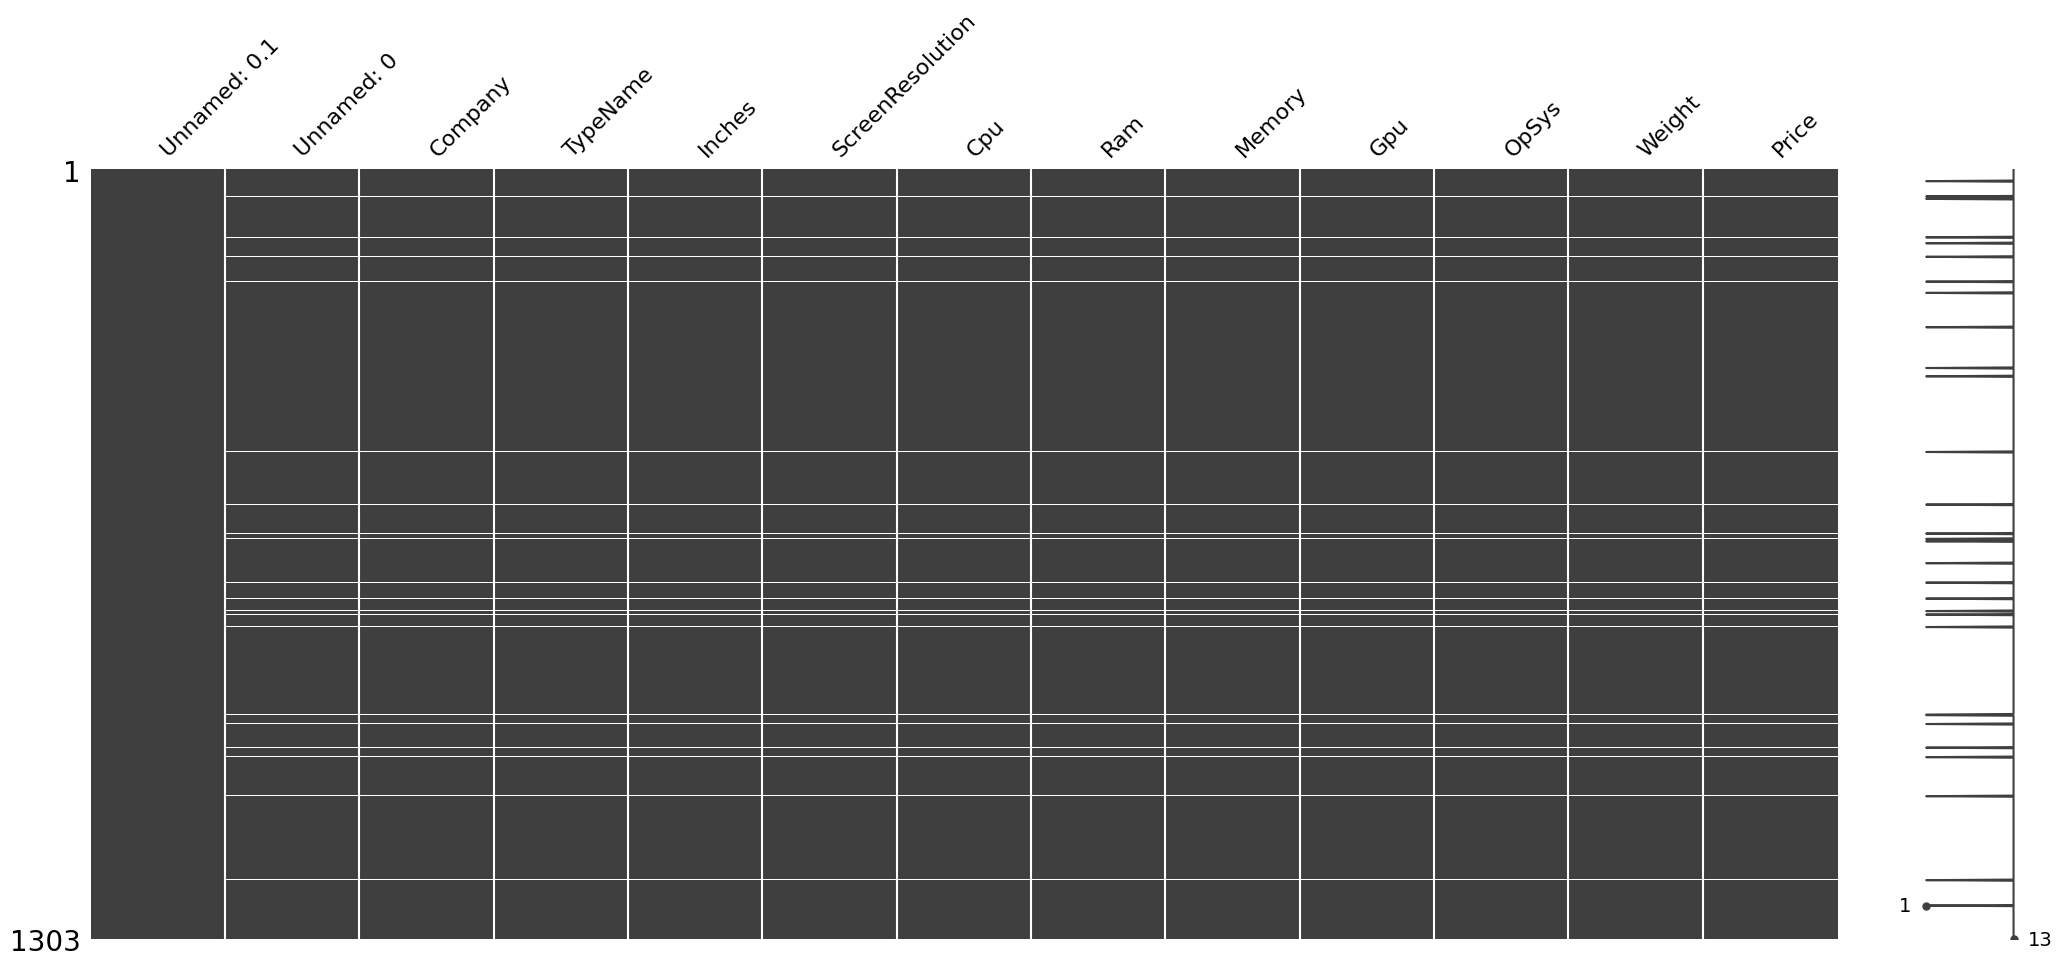

In [114]:
df.isnull().sum()

# checking if one observation has missing values more than 1
Missing_I = df.isnull().sum(axis = 1)
Missing_I = Missing_I[Missing_I > 1]
print(Missing_I)
msno.matrix(df)

#No of Duplicates
print("no of dupicates :", df.duplicated().sum())

#Removing Missing values, duplicates and unnecessary columns
df.drop(columns = ['Unnamed: 0.1','Unnamed: 0'], inplace = True)
df = df.dropna(axis=0)
df = df.drop_duplicates()

#Shape after cleaning
print("")
print(df.shape)

Outliers

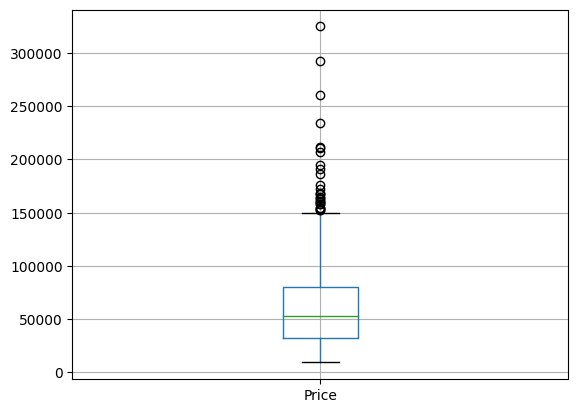

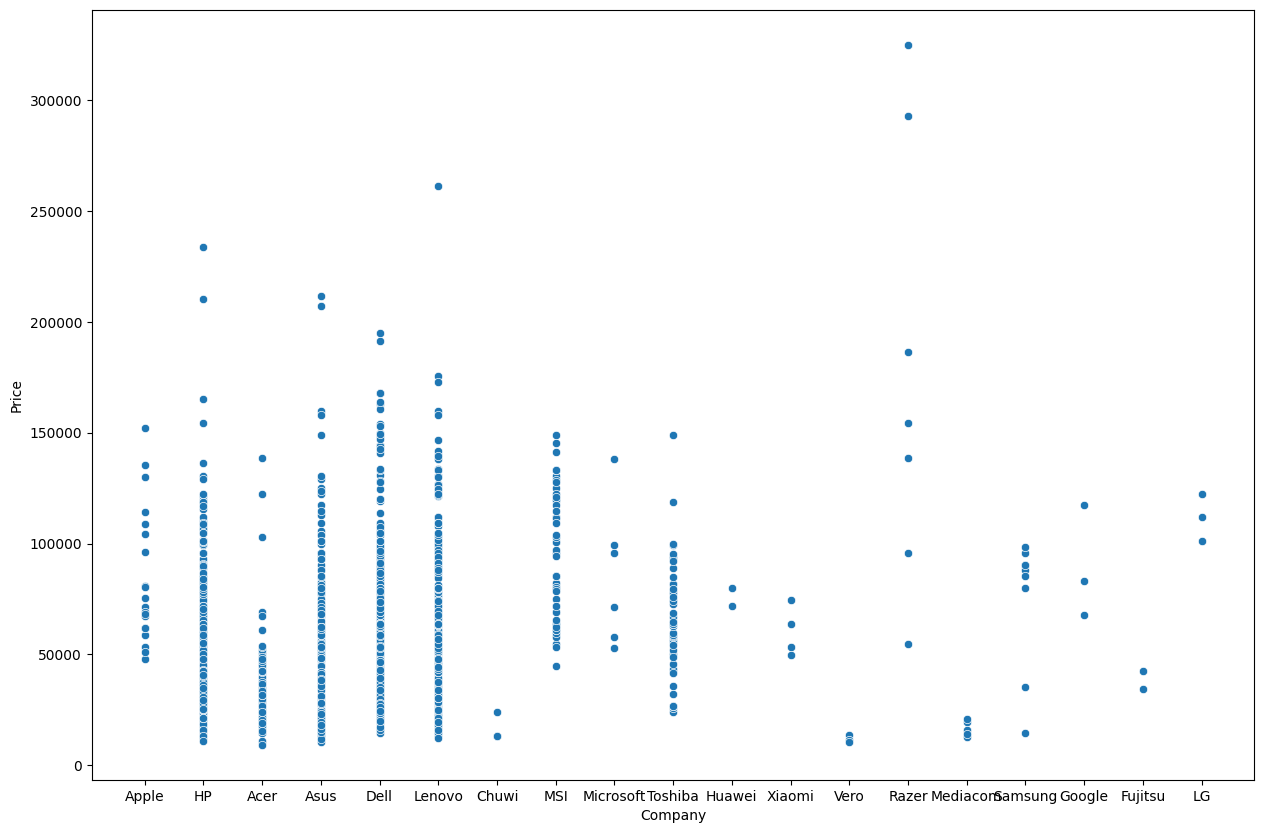

In [115]:
#Checking for outliers through visulisation
df.boxplot()
plt.show
figure=plt.figure(figsize=(15,10))
sns.scatterplot(x='Company',y='Price',data=df)
plt.show()


In [116]:
#Dealing with outliers
Q1=df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
# Clip the outliers
df['Price'] = df['Price'].clip(lower=lower_bound, upper=upper_bound)

<function matplotlib.pyplot.show(close=None, block=None)>

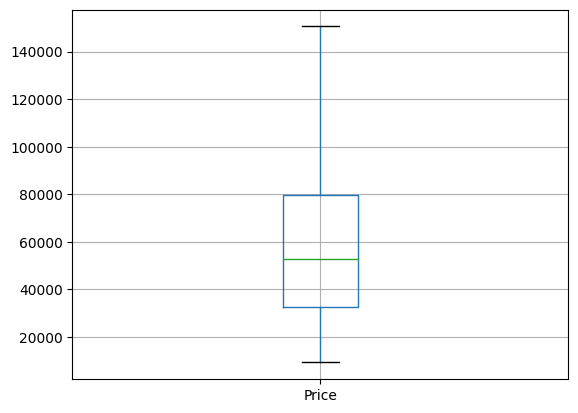

In [117]:
#Checking for outliers after clipping
df.boxplot()
plt.show

#Feature Engineering

Ram Column

In [118]:
#Ram Column
df['Ram'] = df['Ram'].str.replace('GB','')
df['Ram']=df['Ram'].astype(int)

Weight Column

In [119]:
df['Weight'] = df['Weight'].str.replace('kg','')
#Removing Gibberish
df = df[df['Weight'] != '?']
#changing type
df['Weight']=df['Weight'].astype(float)

Inches

In [120]:
#Removing Gibberish
df = df[df['Inches'] != '?']
#changing type
df['Inches']=df['Inches'].astype(float)
#Removing Unacceptable laptop sizes
min_size = 10
max_size = 17.3
df['Inches'].value_counts()
df = df[(df['Inches'] >= min_size) & (df['Inches'] <= max_size)]
#Shape after removing more outliers
print(df.shape)

(1232, 11)


Screen resolution

In [121]:
#Extracting Touchscreen, IPS, and Resolution information
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df['IPS'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)
df['Resolution'] = df['ScreenResolution'].apply(lambda x: x[-9:])

#List of resolution types
resolution_types = ["4K Ultra HD", "Quad HD+", "Retina Display", "Full HD"]

#Function to extract resolution type from ScreenResolution
df['ResolutionType'] = df['ScreenResolution'].apply(
    lambda x: next((rt for rt in resolution_types if rt.lower() in x.lower()), ""))


# Drop the original column if it's no longer needed
df.drop(columns=['ScreenResolution'], inplace=True)

In [122]:
# Replace empty values with 'Unknown'
df['ResolutionType'].replace("", "Unknown", inplace=True)
print(df['ResolutionType'].value_counts())

ResolutionType
Full HD           809
Unknown           337
4K Ultra HD        42
Quad HD+           27
Retina Display     17
Name: count, dtype: int64


CPU

In [123]:
# Extract CPU brand
df['CPU_Brand'] = df['Cpu'].apply(lambda x: x.split()[0])

# Extract CPU series
df['CPU_Series'] = df['Cpu'].apply(lambda x: ' '.join(x.split()[1:-1]))

# Extract CPU clock speed
df['CPU_ClockSpeed'] = df['Cpu'].apply(lambda x: x.split()[-1])
# Remove 'GHz' and convert the values to float
df['CPU_ClockSpeed'] = df['CPU_ClockSpeed'].str.replace('GHz', '').astype(float)

def categorize_cpu(cpu):
    if 'Core i3' in cpu or 'Core i5' in cpu or 'Core i7' in cpu or 'Core i9' in cpu:
        return 'Intel Core'
    elif 'Core M' in cpu:
        return 'Intel Core M'
    elif 'Xeon' in cpu:
        return 'Intel Xeon'
    elif 'Ryzen' in cpu:
        return 'AMD Ryzen'
    elif 'A-Series' in cpu or 'FX' in cpu:
        return 'AMD A-Series/FX-Series'
    elif 'Celeron' in cpu or 'Pentium' in cpu:
        return 'Intel Celeron/Pentium'
    elif 'Atom' in cpu:
        return 'Intel Atom'
    else:
        return 'Other'

# Apply categorization
df['CPU_Series'] = df['CPU_Series'].apply(categorize_cpu)

#Drop orginal
df.drop(columns=['Cpu'], inplace=True)

GPU


In [124]:
# GPU Brand Extraction
df['GPU_Brand'] = df['Gpu'].apply(lambda x: x.split()[0])

df.drop(columns=['Gpu'], inplace=True)

Memory

In [125]:
# primary storage type
df['Primary_Storage'] = df['Memory'].apply(lambda x: ' '.join(x.split()[:2]))

#secondary storage (if exists)
df['Secondary_Storage'] = df['Memory'].apply(lambda x: x.split('+')[1].strip() if '+' in x else 'None')

#Drop Initial memory
df.drop(columns=['Memory'], inplace=True)

#Removing Gibberish
df = df[df['Primary_Storage'] != '?']

#Print to check
print(df['Primary_Storage'].unique())
print(df['Secondary_Storage'].unique())

['128GB SSD' '128GB Flash' '256GB SSD' '512GB SSD' '500GB HDD'
 '256GB Flash' '1TB HDD' '64GB Flash' '32GB Flash' '32GB SSD' '2TB HDD'
 '64GB SSD' '1.0TB Hybrid' '1TB SSD' '16GB SSD' '16GB Flash' '180GB SSD'
 '32GB HDD' '512GB Flash' '128GB HDD' '240GB SSD' '8GB SSD' '508GB Hybrid'
 '1.0TB HDD']
['None' '1TB HDD' '256GB SSD' '2TB HDD' '500GB HDD' '512GB SSD'
 '1.0TB Hybrid']


Screen Resolution

In [126]:
# Split 'Resolution' into 'Width' and 'Height'
df[['Width', 'Height']] = df['Resolution'].str.split('x', expand=True)

# Convert the new columns to integers
df['Width'] = df['Width'].astype(int)
df['Height'] = df['Height'].astype(int)

# Drop the original 'Resolution' column
df.drop(columns=['Resolution'], inplace=True)

Company, Typename,Opsys does not need transformation

New Column Pixel per Inches

In [127]:
df['PPI'] = np.sqrt(df['Width']**2 + df['Height']**2) / df['Inches']

In [128]:
#After Transformation
print(df.head())
print(df.info())

  Company   TypeName  Inches  Ram  OpSys  Weight        Price  Touchscreen  \
0   Apple  Ultrabook    13.3    8  macOS    1.37   71378.6832            0   
1   Apple  Ultrabook    13.3    8  macOS    1.34   47895.5232            0   
2      HP   Notebook    15.6    8  No OS    1.86   30636.0000            0   
3   Apple  Ultrabook    15.4   16  macOS    1.83  135195.3360            0   
4   Apple  Ultrabook    13.3    8  macOS    1.37   96095.8080            0   

   IPS  ResolutionType CPU_Brand  CPU_Series  CPU_ClockSpeed GPU_Brand  \
0    1  Retina Display     Intel  Intel Core             2.3     Intel   
1    0         Unknown     Intel  Intel Core             1.8     Intel   
2    0         Full HD     Intel  Intel Core             2.5     Intel   
3    1  Retina Display     Intel  Intel Core             2.7       AMD   
4    1  Retina Display     Intel  Intel Core             3.1     Intel   

  Primary_Storage Secondary_Storage  Width  Height         PPI  
0       128GB SSD    

#Data Visualisation




Popular Companies

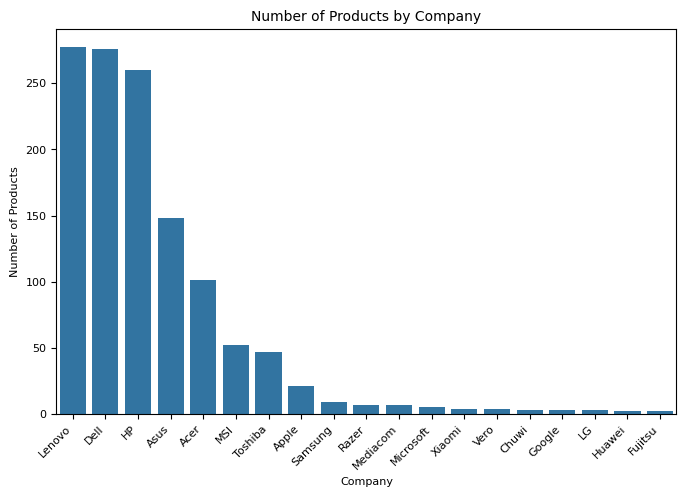

In [129]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Company', data=df,
              order=df['Company'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Products by Company', fontsize=10)
plt.xlabel('Company', fontsize=8)
plt.ylabel('Number of Products', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Most used Operating System


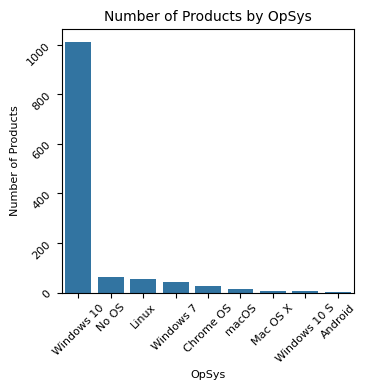

In [130]:
plt.figure(figsize=(10, 4))

for i, feature in enumerate(['OpSys']):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=feature, data=df,
                  order=df[feature].value_counts().index)
    plt.title(f'Number of Products by {feature}', fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel('Number of Products', fontsize=8)
    if i == 0 or i == 2:
        plt.tick_params(rotation=45, axis='both', labelsize=8)
    else:
        plt.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

pie charts for operating system and Laptop types

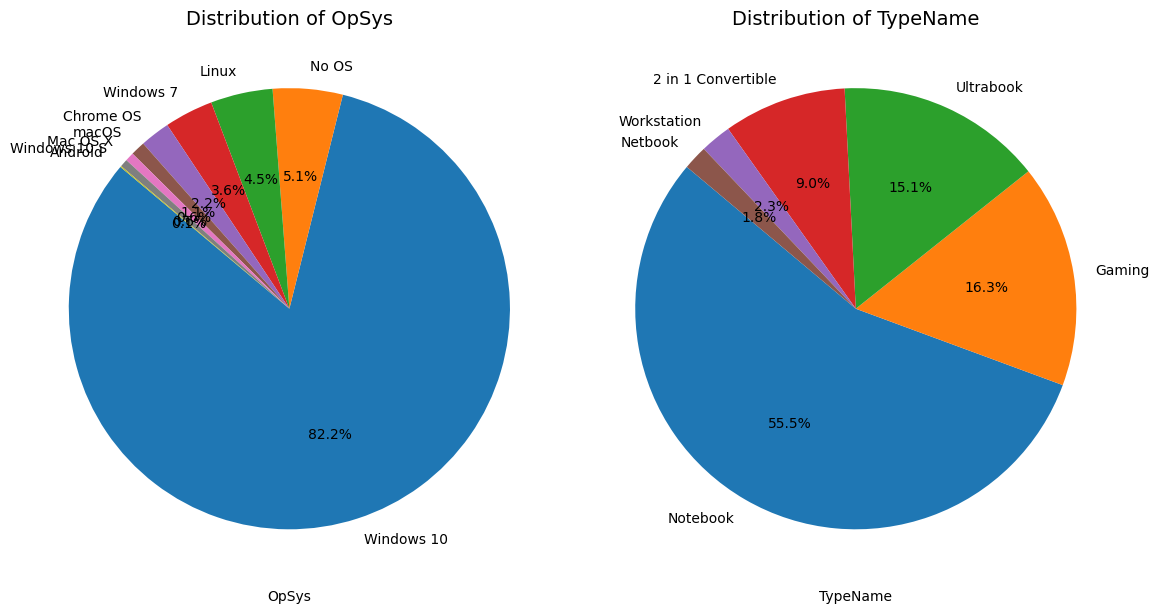

In [131]:
columns_to_plot = ['OpSys', 'TypeName']
plt.figure(figsize=(12, 6))

for i, feature in enumerate(columns_to_plot):
    plt.subplot(1, 2, i + 1)
    counts = df[feature].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=10)

plt.tight_layout()
plt.show()

Which size is the most popular?

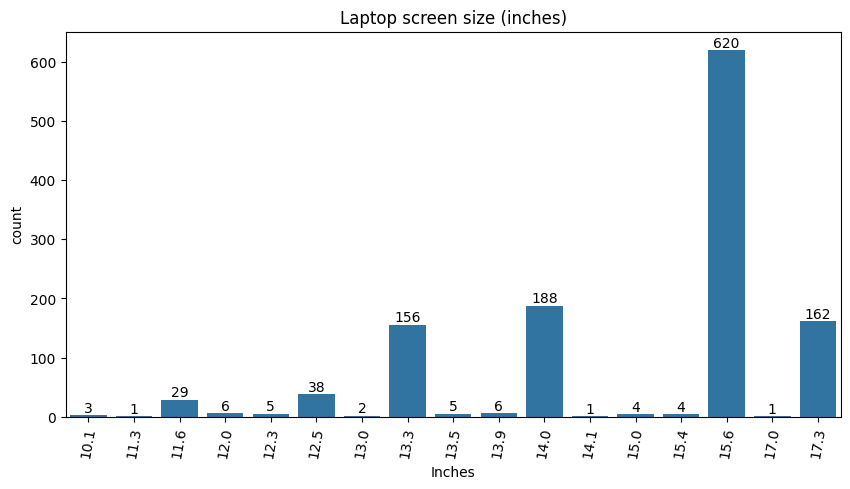

In [132]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='Inches', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);
ax.bar_label(ax.containers[0])
plt.title('Laptop screen size (inches)')
plt.show()

Most used CPU and GPU brand products

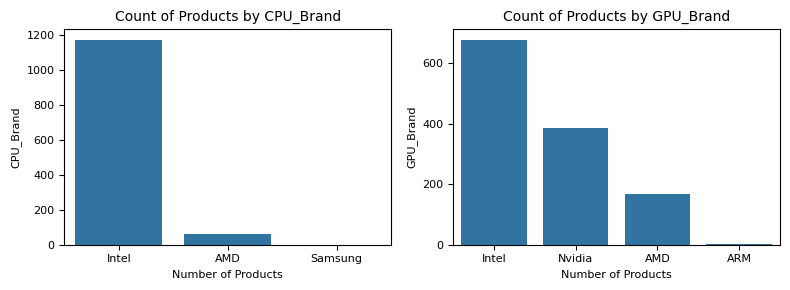

In [133]:
#CPU and GPU brand products
features = ['CPU_Brand', 'GPU_Brand']
plt.figure(figsize=(8, 3))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=feature, data=df,
                  order=df[feature].value_counts().index)
    plt.title(f'Count of Products by {feature}', fontsize=10)
    plt.xlabel('Number of Products', fontsize=8)
    plt.ylabel(feature, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

Number of Products by Memory Type

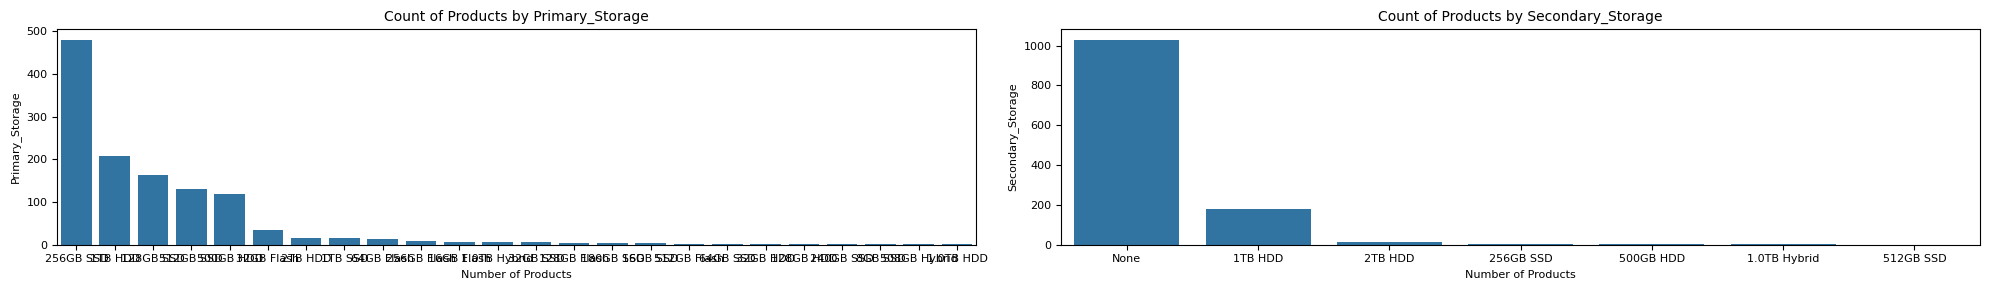

In [153]:
#Number of Products by Memory Type
features = ['Primary_Storage', 'Secondary_Storage']
plt.figure(figsize=(20, 3))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=feature, data=df,order=df[feature].value_counts().index)
    plt.title(f'Count of Products by {feature}', fontsize=10)
    plt.xlabel('Number of Products', fontsize=8)
    plt.ylabel(feature, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

TouchScreen and Price

<Axes: xlabel='Touchscreen', ylabel='Price'>

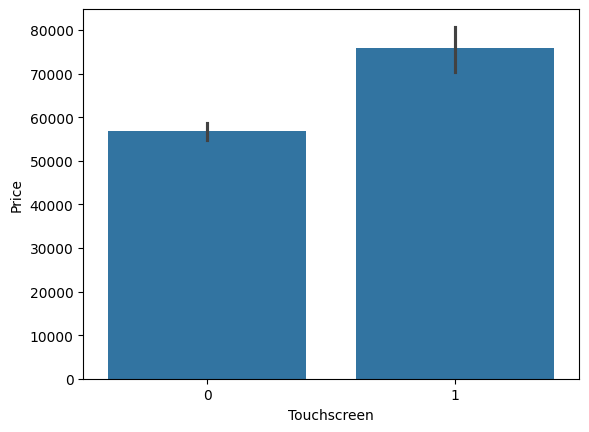

In [135]:
sns.barplot(x=df['Touchscreen'],y=df['Price'])

IPS and Price

<Axes: xlabel='IPS', ylabel='Price'>

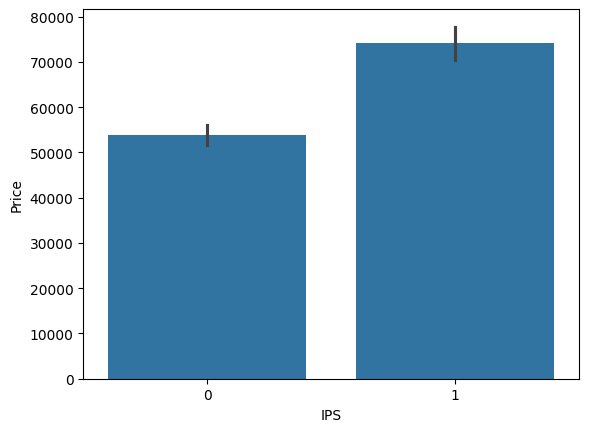

In [136]:
sns.barplot(x=df['IPS'],y=df['Price'])

Correlation Matrix

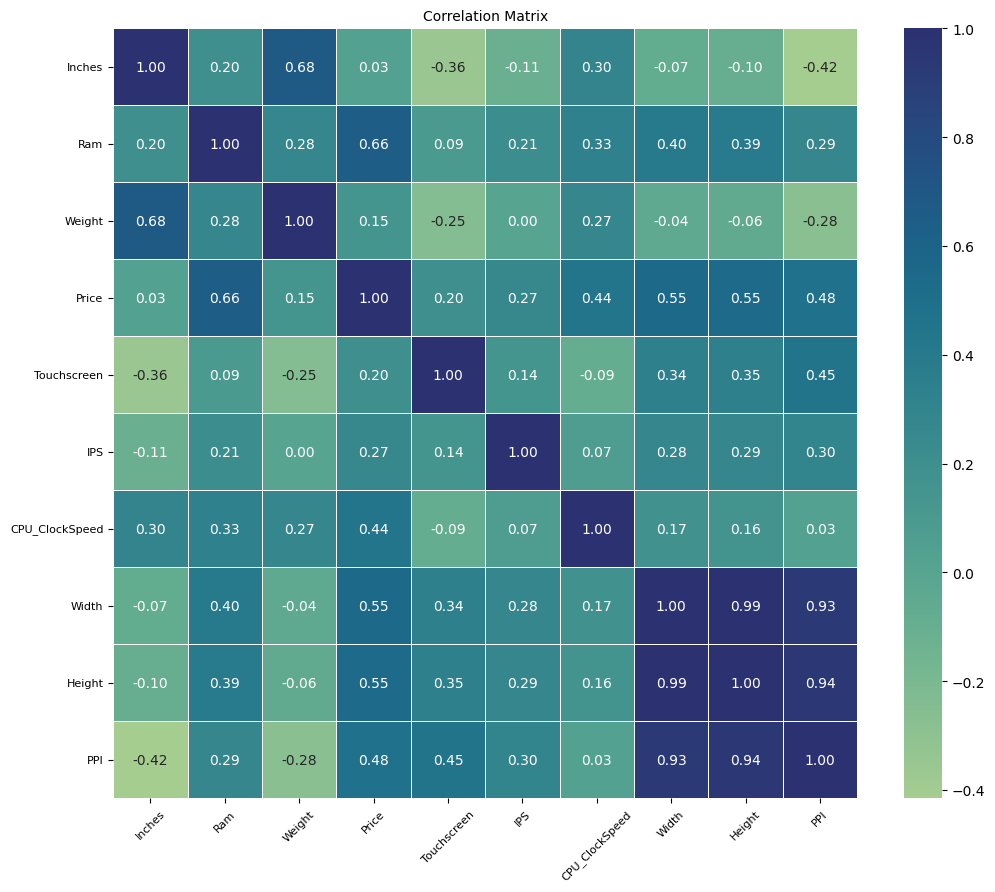

In [137]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Price vs. Inches

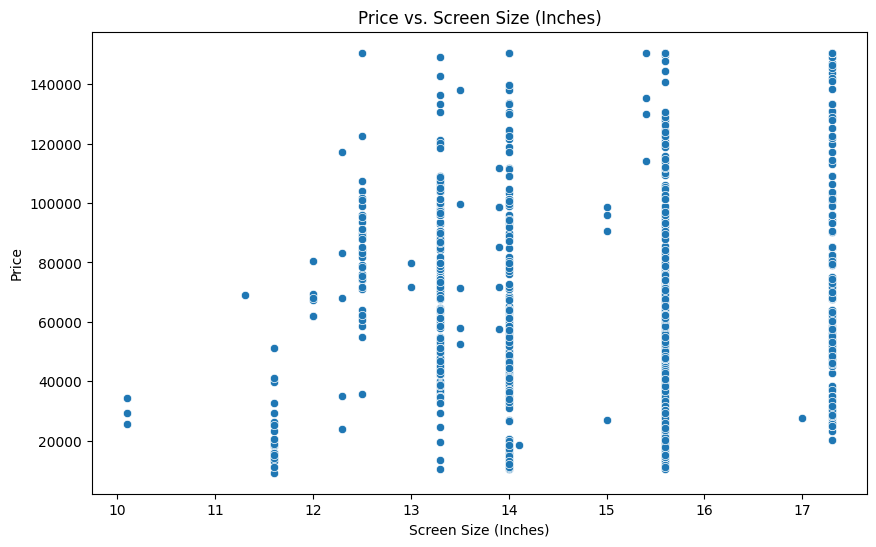

In [138]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Inches', y='Price', data=df)
plt.title('Price vs. Screen Size (Inches)')
plt.xlabel('Screen Size (Inches)')
plt.ylabel('Price')
plt.show()

 Price vs. RAM

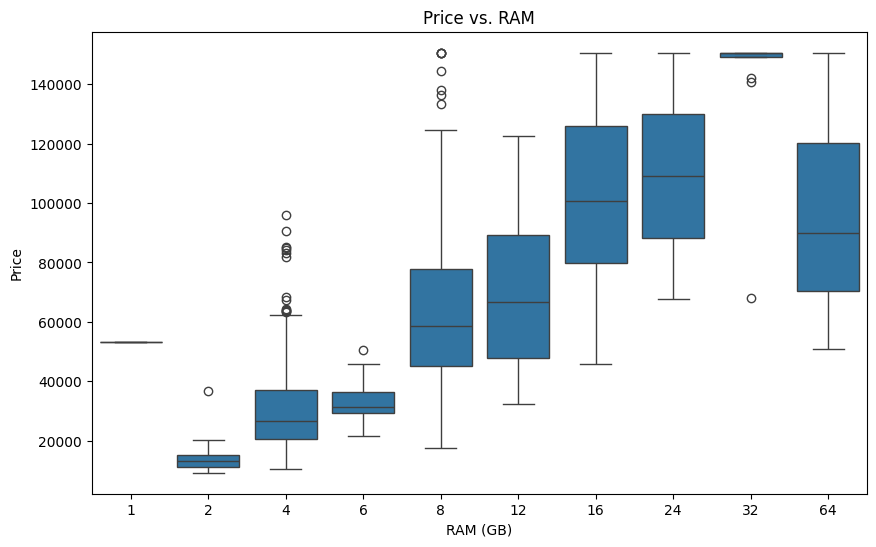

In [139]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ram', y='Price', data=df)
plt.title('Price vs. RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Price')
plt.show()

Price vs. Weight

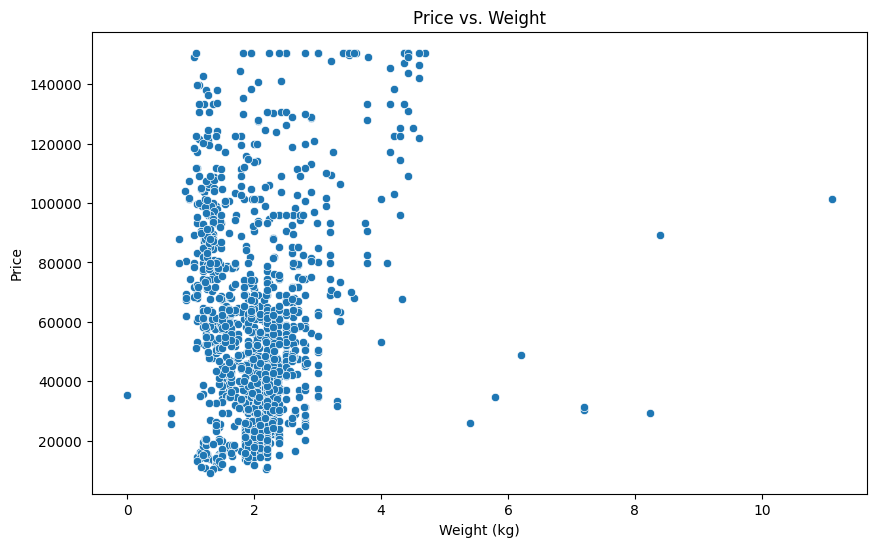

In [140]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Weight', y='Price', data=df)
plt.title('Price vs. Weight')
plt.xlabel('Weight (kg)')
plt.ylabel('Price')
plt.show()

 Price vs. CPU Clock Speed

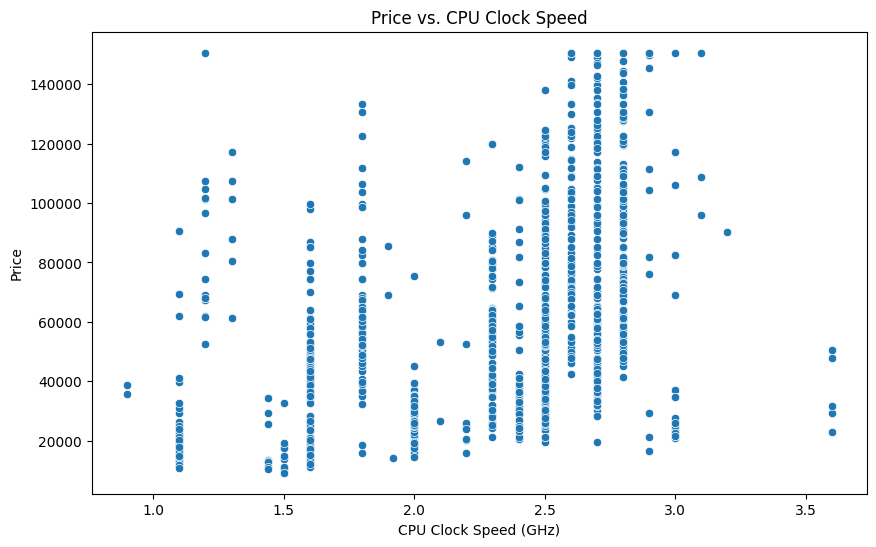

In [141]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CPU_ClockSpeed', y='Price', data=df)
plt.title('Price vs. CPU Clock Speed')
plt.xlabel('CPU Clock Speed (GHz)')
plt.ylabel('Price')
plt.show()

Price vs. PPI

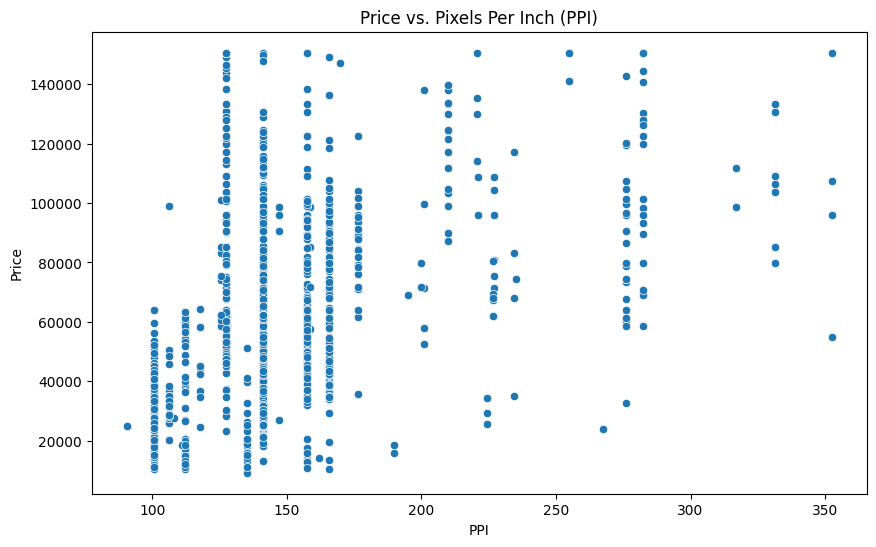

In [142]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PPI', y='Price', data=df)
plt.title('Price vs. Pixels Per Inch (PPI)')
plt.xlabel('PPI')
plt.ylabel('Price')
plt.show()

Price vs. Categorical Columns

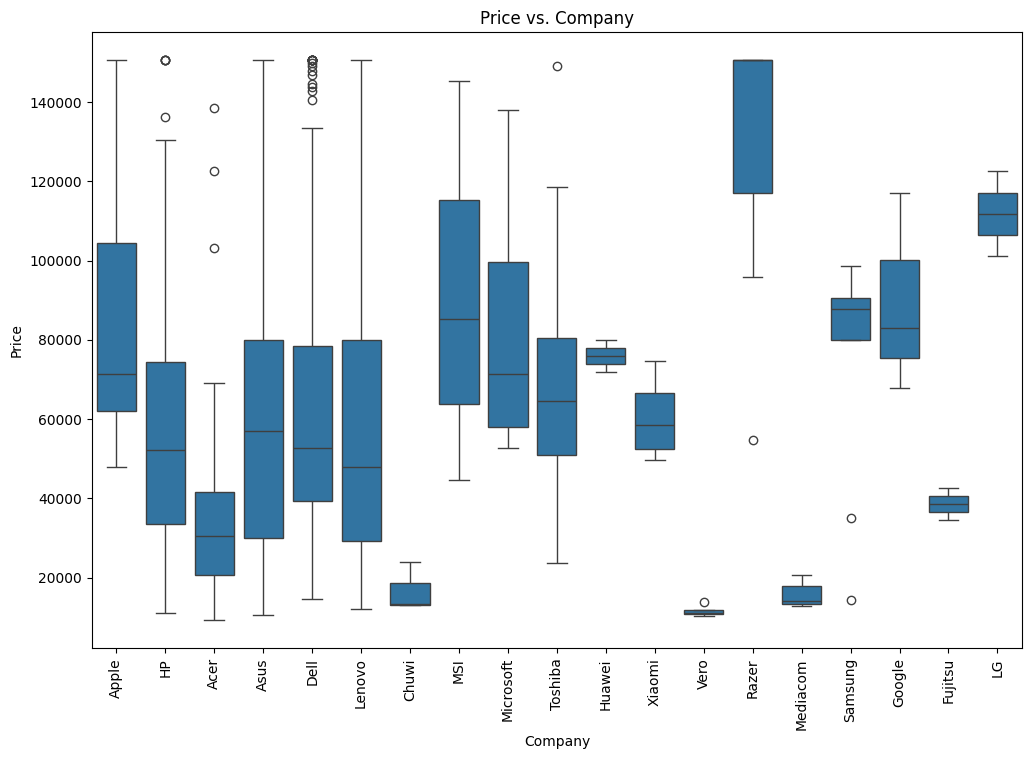

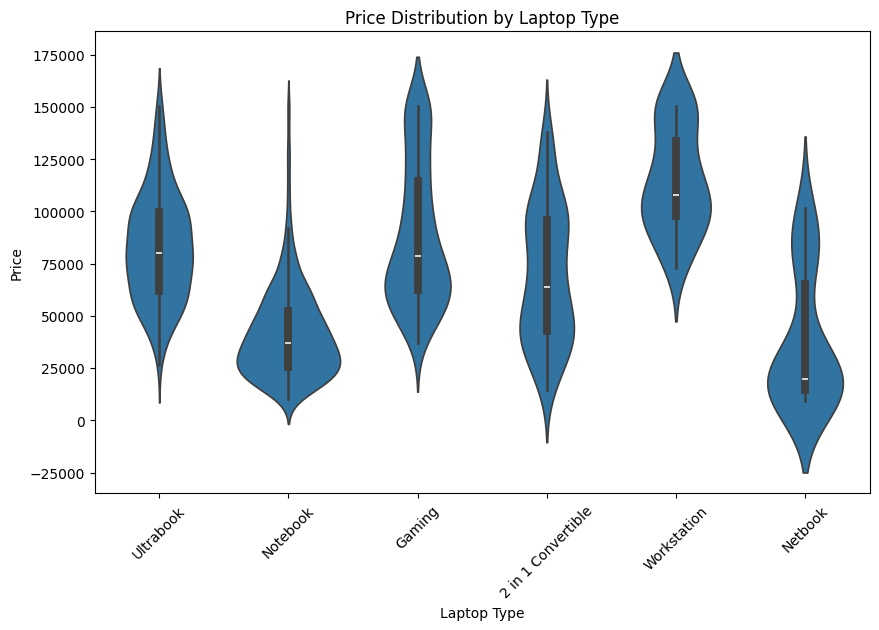

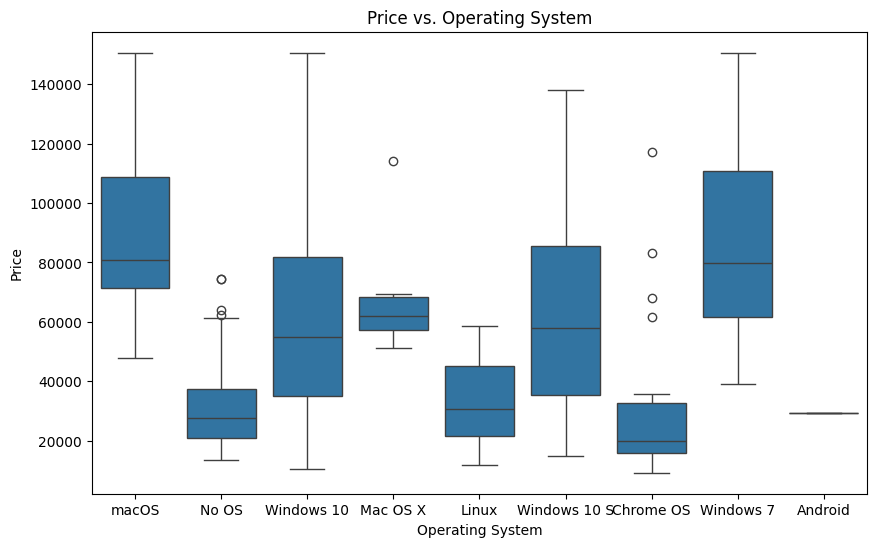

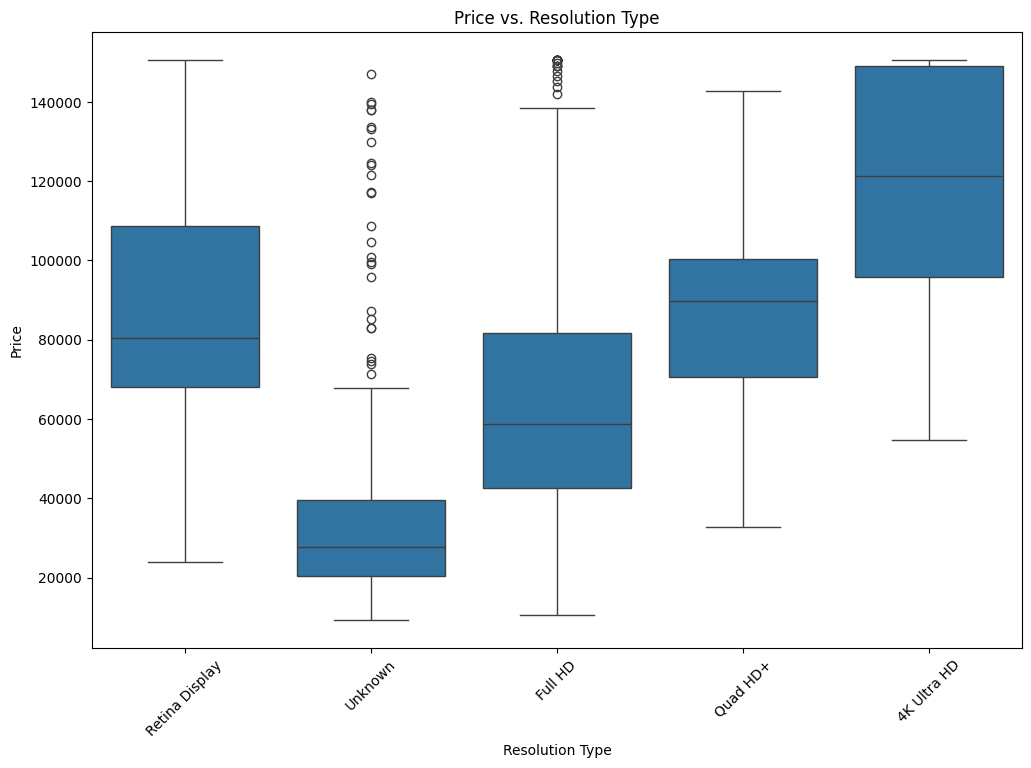

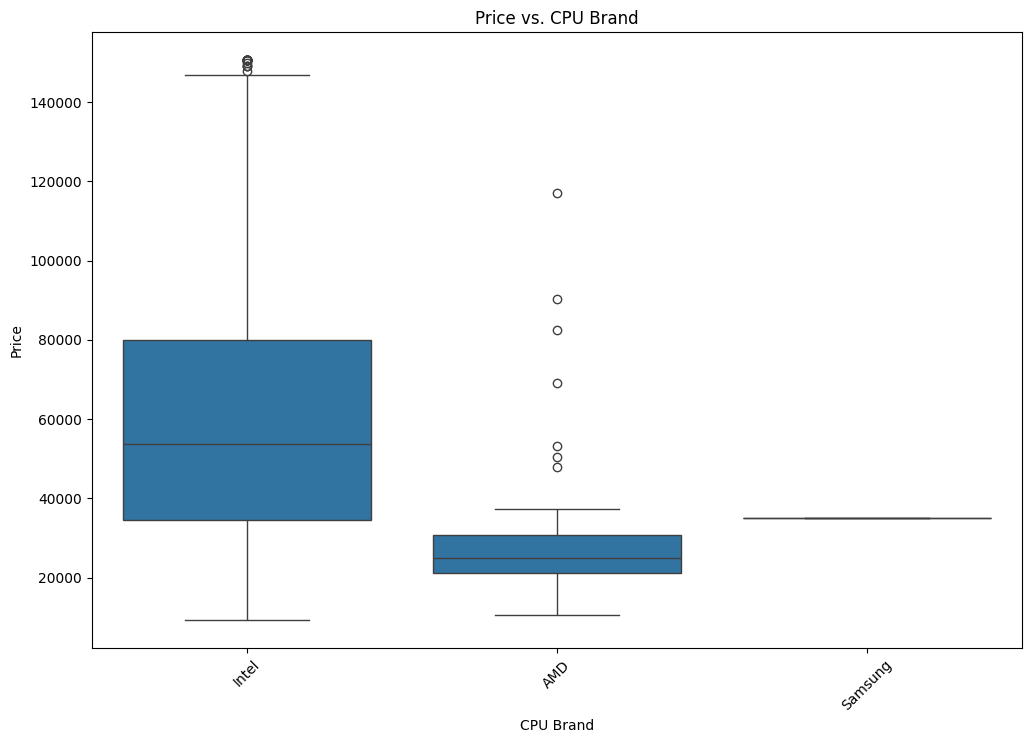

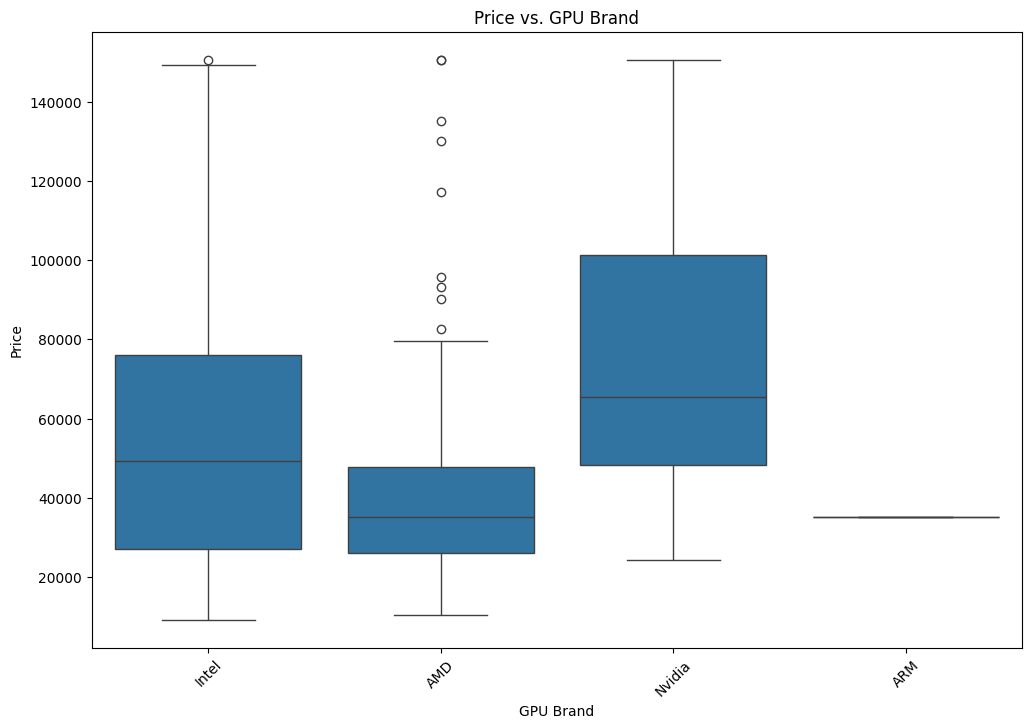

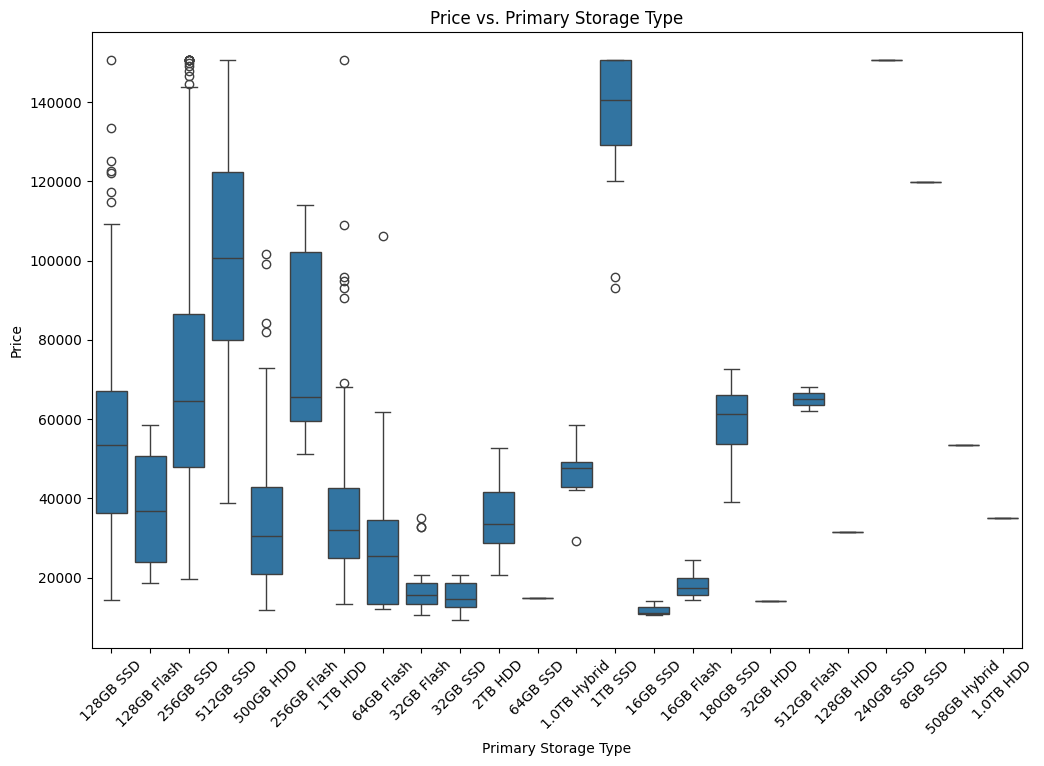

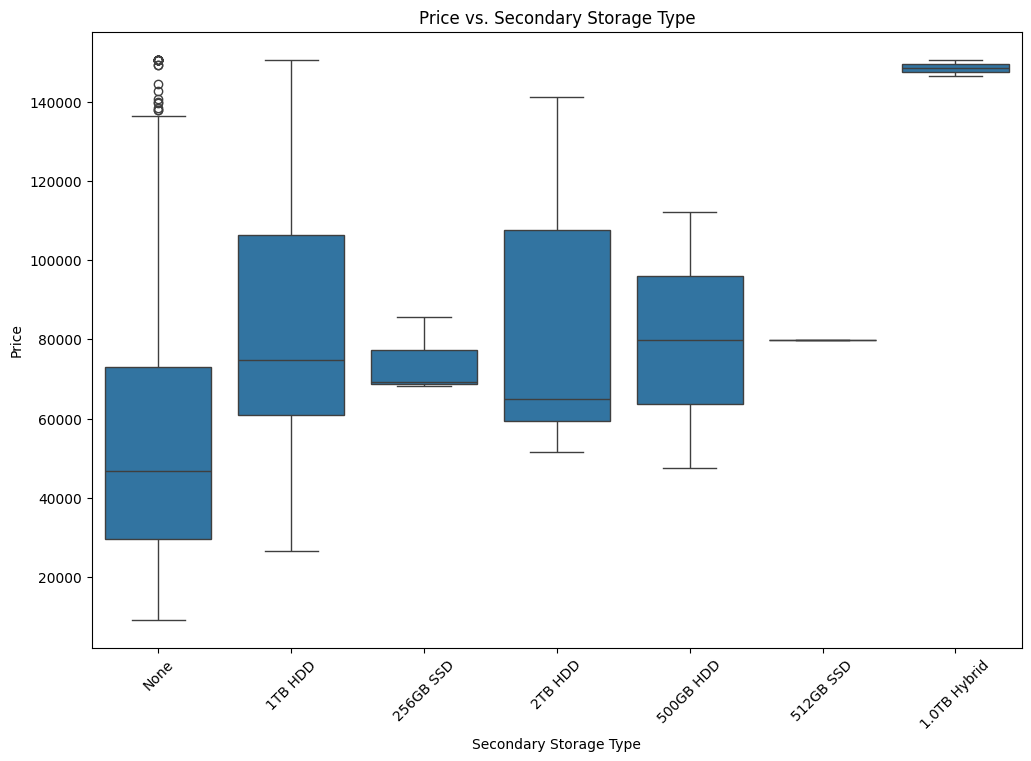

In [143]:
# Price vs. Company
plt.figure(figsize=(12, 8))
sns.boxplot(x='Company', y='Price', data=df)
plt.title('Price vs. Company')
plt.xlabel('Company')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

# Price vs. TypeName
plt.figure(figsize=(10, 6))
sns.violinplot(x='TypeName', y='Price', data=df)
plt.title('Price Distribution by Laptop Type')
plt.xlabel('Laptop Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Price vs. OpSys
plt.figure(figsize=(10, 6))
sns.boxplot(x='OpSys', y='Price', data=df)
plt.title('Price vs. Operating System')
plt.xlabel('Operating System')
plt.ylabel('Price')
plt.show()

# Price vs. ResolutionType
plt.figure(figsize=(12, 8))
sns.boxplot(x='ResolutionType', y='Price', data=df)
plt.title('Price vs. Resolution Type')
plt.xlabel('Resolution Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Price vs. CPU_Brand
plt.figure(figsize=(12, 8))
sns.boxplot(x='CPU_Brand', y='Price', data=df)
plt.title('Price vs. CPU Brand')
plt.xlabel('CPU Brand')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Price vs. GPU_Brand
plt.figure(figsize=(12, 8))
sns.boxplot(x='GPU_Brand', y='Price', data=df)
plt.title('Price vs. GPU Brand')
plt.xlabel('GPU Brand')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Price vs. Primary_Type
plt.figure(figsize=(12, 8))
sns.boxplot(x='Primary_Storage', y='Price', data=df)
plt.title('Price vs. Primary Storage Type')
plt.xlabel('Primary Storage Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Price vs. Secondary_Type
plt.figure(figsize=(12, 8))
sns.boxplot(x='Secondary_Storage', y='Price', data=df)
plt.title('Price vs. Secondary Storage Type')
plt.xlabel('Secondary Storage Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Price Distribution

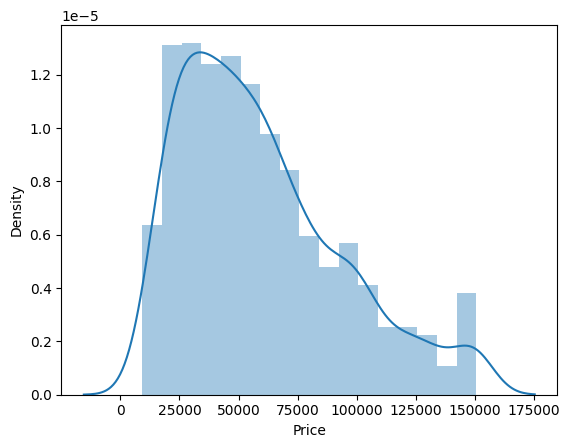

In [144]:
sns.distplot(df['Price'])
plt.show()

In [145]:
# Applying log transformation to fix the right Skewd Graph
df['Price'] = np.log(df['Price'])

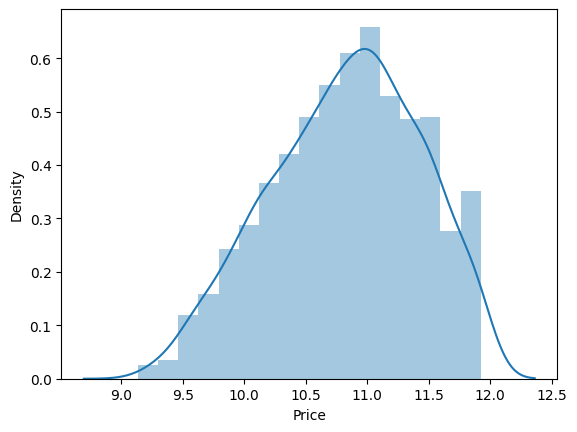

In [146]:
#After fixing
sns.distplot(df['Price'])
plt.show()

Numerical Columns

In [147]:
numerical_features = df.select_dtypes(include=['number'])
# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Extract the correlation of each feature with 'Price'
price_correlation = correlation_matrix['Price'].sort_values(ascending=False)

# Display the correlations
print(price_correlation)

#Drop less correlated columns
numerical_features.drop(columns=['Width','Height','Inches','Weight','Touchscreen','IPS','Price'], inplace=True)
df.drop(columns=['Width','Height','Inches','Weight','Touchscreen','IPS'], inplace=True)

Price             1.000000
Ram               0.613166
Width             0.539688
Height            0.537422
CPU_ClockSpeed    0.498515
PPI               0.480852
IPS               0.284165
Touchscreen       0.195212
Weight            0.113221
Inches            0.021896
Name: Price, dtype: float64


#Data Pre-Processing anf Encoding

Categorical Columns

In [148]:
#Seperatin target variable from other features
Y=df['Price']
X=df.drop(columns=['Price'])

#Categorical features into nomial and ordinal
Nominal=['Company','TypeName','OpSys','CPU_Brand','CPU_Series','GPU_Brand','Primary_Storage','Secondary_Storage']
Ordinal=['ResolutionType']

#OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the nominal columns
transformed = encoder.fit_transform(X[Nominal])

# Convert into a DataFrame with appropriate column names
transformed_df = pd.DataFrame(transformed, columns=encoder.get_feature_names_out(Nominal))

# Reset the index of the transformed DataFrame to match the original DataFrame
transformed_df.index = X.index

# Drop the original nominal columns and add the new encoded columns
X = X.drop(columns=Nominal).join(transformed_df)

# Apply LabelEncoder for Ordinal features
for col in Ordinal:
    X[col] = LabelEncoder().fit_transform(X[col])

for col in numerical_features:
    X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1,1))

In [149]:
#after encoding
X.columns

Index(['Ram', 'ResolutionType', 'CPU_ClockSpeed', 'PPI', 'Company_Acer',
       'Company_Apple', 'Company_Asus', 'Company_Chuwi', 'Company_Dell',
       'Company_Fujitsu', 'Company_Google', 'Company_HP', 'Company_Huawei',
       'Company_LG', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom',
       'Company_Microsoft', 'Company_Razer', 'Company_Samsung',
       'Company_Toshiba', 'Company_Vero', 'Company_Xiaomi',
       'TypeName_2 in 1 Convertible', 'TypeName_Gaming', 'TypeName_Netbook',
       'TypeName_Notebook', 'TypeName_Ultrabook', 'TypeName_Workstation',
       'OpSys_Android', 'OpSys_Chrome OS', 'OpSys_Linux', 'OpSys_Mac OS X',
       'OpSys_No OS', 'OpSys_Windows 10', 'OpSys_Windows 10 S',
       'OpSys_Windows 7', 'OpSys_macOS', 'CPU_Brand_AMD', 'CPU_Brand_Intel',
       'CPU_Brand_Samsung', 'CPU_Series_AMD A-Series/FX-Series',
       'CPU_Series_AMD Ryzen', 'CPU_Series_Intel Atom',
       'CPU_Series_Intel Celeron/Pentium', 'CPU_Series_Intel Core',
       'CPU_Series_Inte

#Model Development

In [150]:
# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Defining regression models
regressors = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor()
}

# List to store metrics data
model_metrics = {}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Training and evaluating each regressor
for name, reg in regressors.items():
    # Train the regressor
    reg.fit(X_train, y_train)

    # Predict on test set
    y_pred = reg.predict(X_test)

    # Evaluate the regressor
    n = len(y_test)  # number of samples
    k = X_test.shape[1]  # number of predictors
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, n, k)

    # Store metrics
    model_metrics[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2,
        'Adjusted R^2': adj_r2
    }

# Convert metrics dictionary to a DataFrame for easy viewing
metrics_df = pd.DataFrame(model_metrics).T

# Display the metrics table
print(metrics_df)


                           MAE           MSE          RMSE           R^2  \
LinearRegression  2.439130e+09  1.021094e+21  3.195457e+10 -2.887050e+21   
DecisionTree      2.020717e-01  7.229450e-02  2.688764e-01  7.955940e-01   
RandomForest      1.647886e-01  4.519652e-02  2.125947e-01  8.722110e-01   
GradientBoosting  1.800463e-01  5.163259e-02  2.272281e-01  8.540136e-01   
SVR               1.696675e-01  4.867863e-02  2.206323e-01  8.623657e-01   
XGBoost           1.560333e-01  4.014732e-02  2.003680e-01  8.864871e-01   

                  Adjusted R^2  
LinearRegression -4.384039e+21  
DecisionTree      6.896057e-01  
RandomForest      8.059501e-01  
GradientBoosting  7.783170e-01  
SVR               7.909997e-01  
XGBoost           8.276286e-01  


#Hyperparameter Tuning

Hyperparameter Tuning and Feature Imporatance

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Score: 0.8619461818671758
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best XGBoost Score: 0.8792354700158216


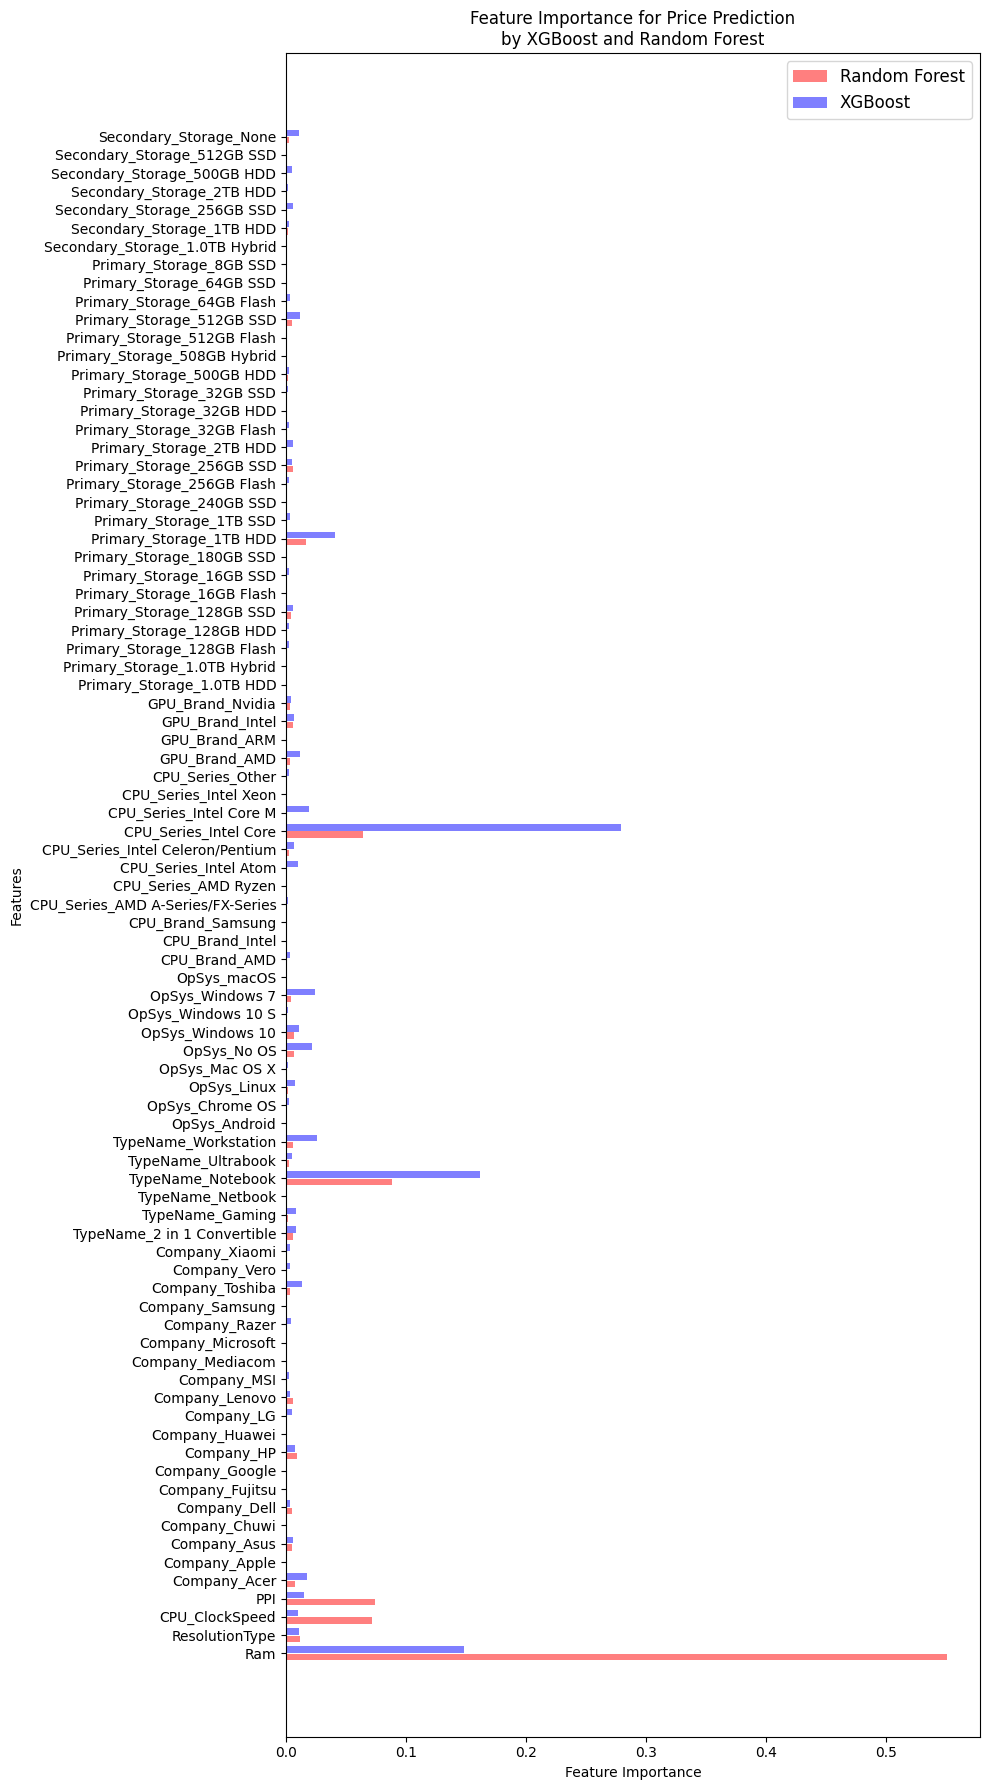

In [151]:
# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=rf_params, cv=5, n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)

print(f"Best Random Forest Params: {rf_grid.best_params_}")
print(f"Best Random Forest Score: {rf_grid.best_score_}")

# Hyperparameter Tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
}

xgb_grid = GridSearchCV(estimator=XGBRegressor(random_state=42),
                        param_grid=xgb_params, cv=5, n_jobs=-1, verbose=2)
xgb_grid.fit(X_train, y_train)

print(f"Best XGBoost Params: {xgb_grid.best_params_}")
print(f"Best XGBoost Score: {xgb_grid.best_score_}")

# Feature Importance Visualization for Random Forest and XGBoost
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

rf_importances = best_rf.feature_importances_
xgb_importances = best_xgb.feature_importances_

# Plotting Feature Importance
plt.figure(figsize=(10, 18))
plt.barh(np.arange(len(X_train.columns)), rf_importances, alpha=0.5, label='Random Forest', color='red', height=0.35)
plt.barh(np.arange(len(X_train.columns)) + 0.4, xgb_importances, alpha=0.5, label='XGBoost', color='blue', height=0.35)

plt.yticks(np.arange(len(X_train.columns)) + 0.2, X_train.columns)

plt.legend(loc='best', fontsize=12)
plt.title('Feature Importance for Price Prediction\nby XGBoost and Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Gradio Implementation

In [152]:

def predict_price(Company, Typename, Ram, Opsys, CPU_Brand, CPU_Series,CPU_Clock, GPU_brand, Primary_Storage, Secondary_Storage, Resolution_Type, ppi):
    # Prepare the input data
    input_data = {
        'Company': Company,
        'TypeName': Typename,
        'Ram': Ram,
        'OpSys': Opsys,
        'CPU_Brand': CPU_Brand,
        'CPU_Series': CPU_Series,
        'CPU_ClockSpeed': CPU_Clock,
        'GPU_Brand': GPU_brand,
        'Primary_Storge':  Primary_Storage,
        'Secondary_Storage': Secondary_Storage,
        'ResolutionType': Resolution_Type,
        'PPI': ppi,
    }
    input_df = pd.DataFrame([input_data])


    # Instantiate the OneHotEncoder
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # Fit and transform the nominal columns
    transformed = encoder.fit_transform(input_df[Nominal])

    # Convert the transformed data back into a DataFrame with appropriate column names
    transformed_df = pd.DataFrame(transformed, columns=encoder.get_feature_names_out(Nominal))

    # Reset the index of the transformed DataFrame to match the original DataFrame
    transformed_df.index = input_df.index

    # Drop the original nominal columns and add the new encoded columns
    input_df = input_df.drop(columns=Nominal).join(transformed_df)

    # Apply LabelEncoder to Ordinal features
    for col in Ordinal:
        input_df[col] = LabelEncoder().fit_transform(input_df[col])

    for col in numerical_features:
        input_df[col] = StandardScaler().fit_transform(input_df[col].values.reshape(-1,1))


    # Predict the price using the best model (Random Forest in this case)
    predicted_log_price = best_rf.predict(input_df)
    predicted_price = np.exp(predicted_log_price)  # Since we applied log transformation earlier

    return round(predicted_price[0], 2)

# Define Gradio interface
inputs = [
    gr.Dropdown(list(df['Company'].unique()), label="Company"),
    gr.Dropdown(list(df['TypeName'].unique()), label="TypeName"),
    gr.Slider(minimum=4, maximum=64, step=2, label="RAM (GB)"),
    gr.Dropdown(list(df['OpSys'].unique()), label="Operating System"),
    gr.Dropdown(list(df['CPU_Brand'].unique()), label="CPU Brand"),
    gr.Dropdown(list(df['CPU_Series'].unique()), label="CPU Series"),
    gr.Slider(minimum=1.0, maximum=5.0, step=0.1, label="CPU Clock Speed (GHz)"),
    gr.Dropdown(list(df['GPU_Brand'].unique()), label="GPU Brand"),
    gr.Dropdown(list(df['Primary_Storage'].unique()), label="Primary Storage Type"),
    gr.Dropdown(list(df['Secondary_Storage'].unique()), label="Secondary Storage Type"),
    gr.Dropdown(list(df['ResolutionType'].unique()), label="Resolution Type"),
    gr.Slider(minimum=100, maximum=400, step=1, label="PPI"),
]

output = gr.Textbox(label="Predicted Price ($)")

interface = gr.Interface(fn=predict_price, inputs=inputs, outputs=output, title="Laptop Price Prediction", description="Predict laptop prices based on features.")

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0c1ffbded0de0491f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


HighEnd Vs Budget

Comparing

•**	Which features have the most significant impact on laptop prices?**
According to the Feature Importance graph and Correlations,
Ram-->TypeName(Especially Notebook) -->CPU_Series(Interl_Core)-->Cpu_clockspeed -->PPI these have a greater impact compared to the rest of the features

•	**Can the model accurately predict the prices of laptops from lesser-known brands?**
Yes it can the Dataset is cleaned to include all the laptop brands however there is less data from the lesser known brands so the model might not be very much accurate.

•	**Does the brand of the laptop significantly influence its price?**
Not very much however according the feature importance Acer and Toshiba impact the price compared to other company brands.

•**	How well does the model perform on laptops with high-end specifications compared to budget laptops?**


**•	What are the limitations and challenges in predicting laptop prices accurately?**
Restricted Data: The dataset may not contain all characteristics that influence laptop costs (e.g., brand reputation, warranty, or after-sales service).
High Feature Dimensionality: It can be difficult to include all pertinent interactions in a model because laptops have a wide range of characteristics (CPU, GPU, RAM, storage, etc.) that can interact in complex ways.
Technological Advancements: If the model isn't updated frequently, it may become outdated due to the quick development of new CPU generations and better GPUs, among other things.
Customer Preferences: It is difficult for static models to account for shifts in customer preferences and trends, which can have an impact on laptop costs.

•**	How does the model perform when predicting the prices of newly released laptops not present in the training dataset?**


#Conclusion
The research to anticipate laptop pricing based on different specs was effective in developing and assessing models. When compared to simpler models, the analysis demonstrated that ensemble methods such as Random Forest and Gradient Boosting performed better, with reduced errors and higher predicted accuracy. Nonetheless, difficulties managing newly released laptops and differences in feature data brought to light the significance of consistent model updates and strong feature engineering. All things considered, the knowledge acquired from this project not only improves knowledge of price drivers but also lays a strong basis for raising forecast accuracy in applications down the road.